## Importieren der notwendigen Bibliotheken

In [21]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

## Definieren die CustomDataset Klasse

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, scores, root_dir, transform=None):
        self.image_paths = image_paths
        self.scores = scores
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        scores = self.scores[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(scores)

## Vorbereitung der Daten

In [3]:
df = pd.read_csv('car_imgs_4000.csv')
image_paths = df['filename'].values
scores = df[['perspective_score_hood', 'perspective_score_backdoor_left']].values

image_paths_train, image_paths_test, scores_train, scores_test = train_test_split(
    image_paths, scores, test_size=0.2, random_state=42)

image_paths_train, image_paths_val, scores_train, scores_val = train_test_split(
    image_paths_train, scores_train, test_size=0.25, random_state=42)

## Definieren der Bildtransformationen und Datenloader

In [4]:
# Liste zum Speichern der Pixelwerte aller Bilder initialisieren
all_pixels = []

# Alle Bilder im Datensatz durchlaufen
for filename in os.listdir('imgs'):
    # Überprüfen, ob die Datei ein Bild ist
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Bild laden
        img_path = os.path.join('imgs', filename)
        img = Image.open(img_path)
        # Bild in ein Numpy-Array umwandeln
        img_array = np.array(img)
        # Pixelwerte des Bildes zur Liste hinzufügen
        all_pixels.append(img_array)

# Liste der Pixelwerte in ein Numpy-Array umwandeln
all_pixels = np.array(all_pixels)

# Mittelwert und Standardabweichung des Datensatzes berechnen
mean_values = np.mean(all_pixels, axis=(0, 1, 2))
std_values = np.std(all_pixels, axis=(0, 1, 2))

print("Mittelwerte des Datensatzes:", mean_values)
print("Standardabweichungen des Datensatzes:", std_values)

Mittelwerte des Datensatzes: [121.94860626 123.29817362 120.69967487]
Standardabweichungen des Datensatzes: [63.50452101 64.29714491 67.81830567]


In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),#Originalgröße:674, 506
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_values/255, std=std_values/255)
])

train_dataset = CustomDataset(image_paths=image_paths_train, scores=scores_train, root_dir='imgs', transform=transform)
val_dataset = CustomDataset(image_paths=image_paths_val, scores=scores_val, root_dir='imgs', transform=transform)
test_dataset = CustomDataset(image_paths=image_paths_test, scores=scores_test, root_dir='imgs', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

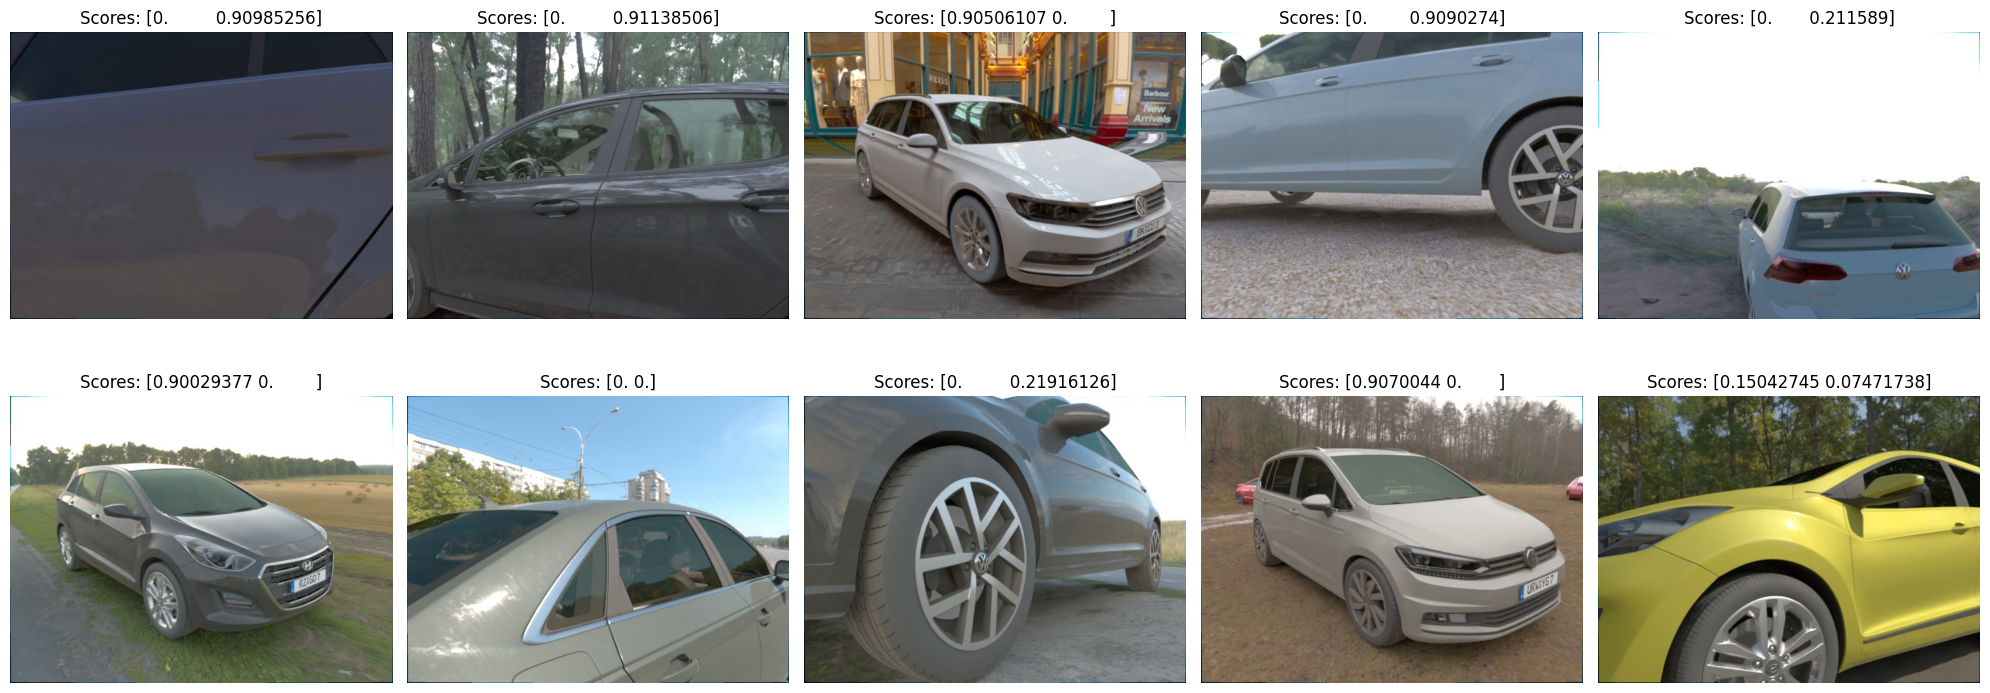

In [34]:
import matplotlib.pyplot as plt

# Extract images from the 6th to the 15th sample from the train_dataset
start_index = 5  # 6th sample
end_index = 15   # 15th sample
num_samples = end_index - start_index
num_cols = 5
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

for i in range(start_index, end_index):
    # Get the image and scores from the dataset
    image_path = train_dataset.image_paths[i]
    scores = train_dataset.scores[i]
    
    # Load the image
    img = Image.open(os.path.join('imgs', image_path))
    
    # Calculate the position in the subplot grid
    row_index = (i - start_index) // num_cols
    col_index = (i - start_index) % num_cols
    
    # Display the image and scores
    axes[row_index, col_index].imshow(img)
    axes[row_index, col_index].set_title(f'Scores: {scores}')
    axes[row_index, col_index].axis('off')

plt.tight_layout()
plt.show()

## Modell, Verlustfunktion und Optimierer definieren

In [15]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Trainieren des Modells mit Validierungsdaten

In [16]:
num_epochs = 10 
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, scores in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Durchschnittlichen Trainingsverlust für diese Epoche berechnen
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, scores in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, scores)
            val_loss += loss.item()
    
    # Durchschnittlichen Validierungsverlust für diese Epoche berechnen
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

Epoch 1, Train Loss: 0.05750364614029725, Val Loss: 0.025546380765736103
Epoch 2, Train Loss: 0.016932630284378927, Val Loss: 0.017161102332174778
Epoch 3, Train Loss: 0.011916221243639787, Val Loss: 0.015292756520211696
Epoch 4, Train Loss: 0.008657300726821025, Val Loss: 0.013825528752058745
Epoch 5, Train Loss: 0.006434128247201442, Val Loss: 0.011723077828064562
Epoch 6, Train Loss: 0.006017467382674416, Val Loss: 0.010760636627674102
Epoch 7, Train Loss: 0.004947312741229931, Val Loss: 0.01095971105620265
Epoch 8, Train Loss: 0.0043878585876276095, Val Loss: 0.010859252326190472
Epoch 9, Train Loss: 0.003854294593135516, Val Loss: 0.010393966659903527
Epoch 10, Train Loss: 0.0037572406496231754, Val Loss: 0.009356724889948964


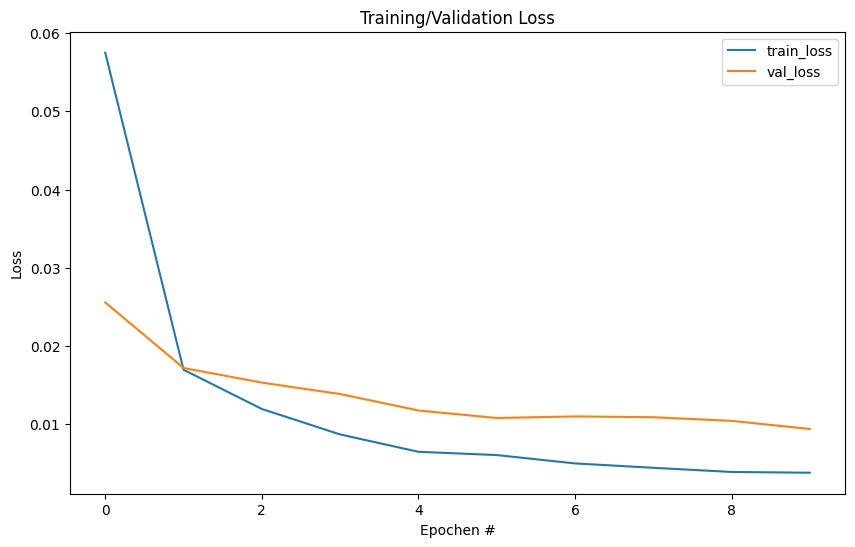

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epochen #')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.legend()
plt.show()

## Evaluierung des Modells auf dem Testset

In [ ]:
model.eval()

In [18]:
total_loss = 0
with torch.no_grad():
    for inputs, scores in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, scores)
        total_loss += loss.item()
average_loss = total_loss / len(test_loader)
print(f'Test Loss: {average_loss:.4f}')

Test Loss: 0.0122


Berechnen Pearson-Korrelation zwischen den vorhergesagten und den tatsächlichen Scores: wie gut die Vorhersagen mit den tatsächlichen Werten übereinstimmen

In [23]:
# Vorhergesagte Scores für Hood (Kapuze)
predicted_scores_hood = []
# Vorhergesagte Scores für Backdoor Left (Hintertür links)
predicted_scores_backdoor_left = []

# Tatsächliche Scores für Hood (Kapuze)
actual_scores_hood = []
# Tatsächliche Scores für Backdoor Left (Hintertür links)
actual_scores_backdoor_left = []

# Inferenz auf dem Testdatensatz durchführen
model.eval()
with torch.no_grad():
    for inputs, scores in test_loader:
        outputs = model(inputs)
        predicted_scores_hood.extend(outputs[:, 0].cpu().numpy())  # Erster Wert für Hood
        predicted_scores_backdoor_left.extend(outputs[:, 1].cpu().numpy())  # Zweiter Wert für Backdoor Left
        actual_scores_hood.extend(scores[:, 0].cpu().numpy())  # Erster Wert für Hood
        actual_scores_backdoor_left.extend(scores[:, 1].cpu().numpy())  # Zweiter Wert für Backdoor Left

# Pearson-Korrelationskoeffizient und p-Werte für Hood berechnen
correlation_hood, p_value_hood = pearsonr(predicted_scores_hood, actual_scores_hood)
print("Pearson-Korrelationskoeffizient für Hood:", correlation_hood)
print("p-Wert für Hood:", p_value_hood)

# Pearson-Korrelationskoeffizient und p-Werte für Backdoor Left berechnen
correlation_backdoor_left, p_value_backdoor_left = pearsonr(predicted_scores_backdoor_left, actual_scores_backdoor_left)
print("Pearson-Korrelationskoeffizient für Backdoor Left:", correlation_backdoor_left)
print("p-Wert für Backdoor Left:", p_value_backdoor_left)

Pearson-Korrelationskoeffizient für Hood: 0.9821799317408403
p-Wert für Hood: 0.0
Pearson-Korrelationskoeffizient für Backdoor Left: 0.9305453852797531
p-Wert für Backdoor Left: 0.0


## Visualization

Um die Ergebnisse Ihres Modells zu visualisieren, indem Sie die fünf besten und die fünf schlechtesten Vorhersagen aus dem Testdatensatz anzeigen

In [19]:
# Speichern alle Bilder, vorhergesagten Werte, tatsächlichen Werte und Fehler
all_images = []
all_predicted_scores = []
all_actual_scores = []
all_errors = []

with torch.no_grad():
    for images, scores in test_loader:
        outputs = model(images)
        errors = torch.abs(outputs - scores).mean(1)  # berechnen die Differenz zwischen den vorhergesagten Werten und den tatsächlichen Werten
        # Ergebnisse speichern
        all_images.extend(images)
        all_predicted_scores.extend(outputs)
        all_actual_scores.extend(scores)
        all_errors.extend(errors)

# Sortieren nach Fehlern und erhalten Sie die Indizes der besten und schlechtesten Vorhersagen
sorted_indices = np.argsort(all_errors)
best_indices = sorted_indices[:5]
worst_indices = sorted_indices[-5:]

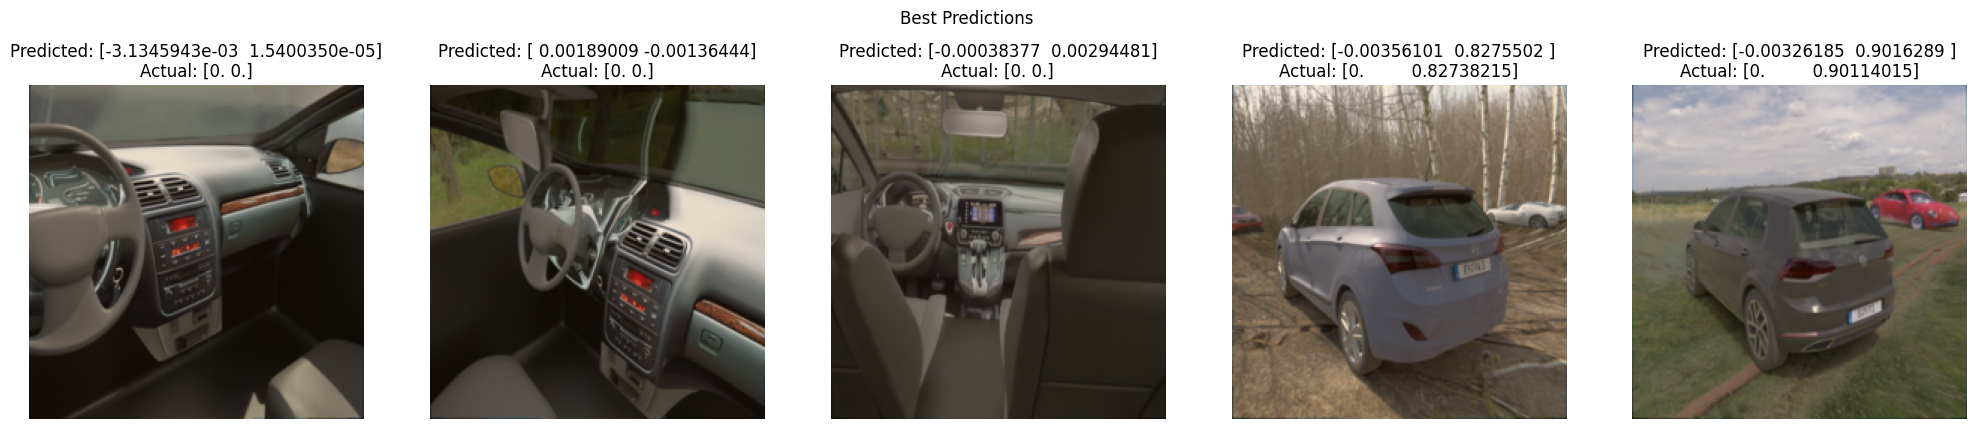

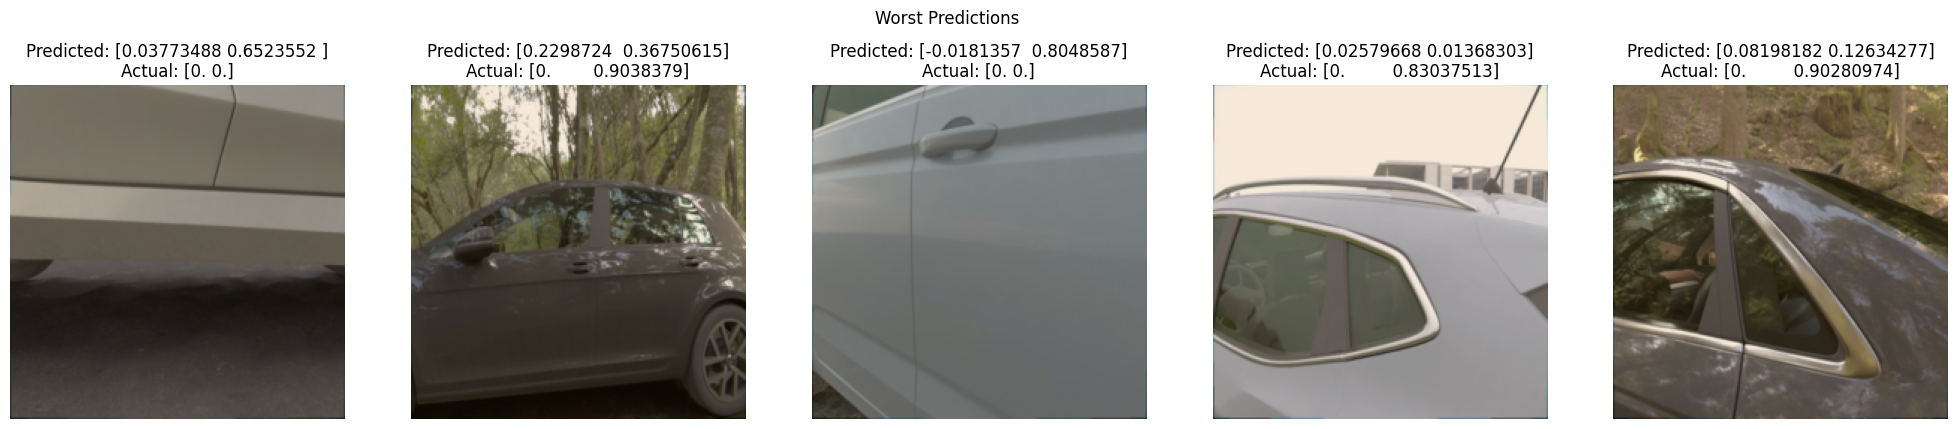

In [20]:
# Visualisierungsfunktion
def visualize_predictions(indices, title):
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for i, idx in enumerate(indices):
        img = all_images[idx].numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        predicted_scores = all_predicted_scores[idx].to('cpu').numpy()
        actual_scores = all_actual_scores[idx].to('cpu').numpy()
        axs[i].imshow(img)
        axs[i].set_title(f'Predicted: {predicted_scores}\nActual: {actual_scores}')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Die besten Vorhersagen visualisieren
visualize_predictions(best_indices, 'Best Predictions')


# Die schlechtesten Vorhersagen visualisieren
visualize_predictions(worst_indices, 'Worst Predictions')